# Treinamento do Modelo Multiclasse

### Importação das bibliotecas
- Habilita Pandas progress_apply

In [1]:
import pandas as pd
import pubchempy as pcp
from tqdm.auto import tqdm
import numpy as np
import itertools
from lib.descriptor_gen import DescriptorGen
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import ConfusionMatrixDisplay, matthews_corrcoef, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

/home/carlosh/ia_web_python/project_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Leitura da base de dados

In [2]:
df = pd.read_csv("data/AID_1645841_datatable.csv",skiprows=[1,2,3,4,5],low_memory=False)

df

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
0,1,104223880,197033.0,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,Active,43,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11111456,5281670.0,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11113977,6604832.0,C[C@H]1[C@@H](C(=O)N[C@H](C(=O)N2CCC[C@@H]2C(=...,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,37.9083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,124879150,5280443.0,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,Active,84,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,6.0081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,124879975,836.0,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,Active,63,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,3.0112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,5238,90341041,11957637.0,C=CCN1CCC23[C@@H]4C(=O)CC[C@]2(C1CC5=C3C(=C(C=...,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5238,5239,90341069,4906.0,CCCNC(C)C(=O)NC1=CC=CC=C1C,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5239,5240,90341160,5593.0,CCN(CC1=CC=NC=C1)C(=O)C(CO)C2=CC=CC=C2,Active,42,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5240,5241,90341654,2968.0,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,1.3450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Tratamento da base de dados

In [3]:
sum(df['PUBCHEM_CID'].isna())

3

In [5]:
df[df['PUBCHEM_CID'].isna()]

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
173,174,144206496,NaN,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,1499,170465762,NaN,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2886,2887,225144377,NaN,NaN,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.dropna(subset=['PUBCHEM_CID'],inplace=True)

df

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
0,1,104223880,197033.0,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,Active,43,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11111456,5281670.0,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11113977,6604832.0,C[C@H]1[C@@H](C(=O)N[C@H](C(=O)N2CCC[C@@H]2C(=...,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,37.9083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,124879150,5280443.0,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,Active,84,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,6.0081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,124879975,836.0,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,Active,63,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,3.0112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,5238,90341041,11957637.0,C=CCN1CCC23[C@@H]4C(=O)CC[C@]2(C1CC5=C3C(=C(C=...,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5238,5239,90341069,4906.0,CCCNC(C)C(=O)NC1=CC=CC=C1C,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5239,5240,90341160,5593.0,CCN(CC1=CC=NC=C1)C(=O)C(CO)C2=CC=CC=C2,Active,42,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5240,5241,90341654,2968.0,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,1.3450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.dtypes

PUBCHEM_RESULT_TAG                    int64
PUBCHEM_SID                           int64
PUBCHEM_CID                         float64
PUBCHEM_EXT_DATASOURCE_SMILES        object
PUBCHEM_ACTIVITY_OUTCOME             object
                                     ...   
Activity at 23.94 uM-Replicate_5    float64
Activity at 57.45 uM-Replicate_5    float64
Activity at 115.4 uM-Replicate_5    float64
Activity at 193.5 uM-Replicate_5    float64
Activity at 288.3 uM-Replicate_5    float64
Length: 204, dtype: object

In [8]:
df['PUBCHEM_CID'] = df['PUBCHEM_CID'].astype(int)

df.dtypes

PUBCHEM_RESULT_TAG                    int64
PUBCHEM_SID                           int64
PUBCHEM_CID                           int64
PUBCHEM_EXT_DATASOURCE_SMILES        object
PUBCHEM_ACTIVITY_OUTCOME             object
                                     ...   
Activity at 23.94 uM-Replicate_5    float64
Activity at 57.45 uM-Replicate_5    float64
Activity at 115.4 uM-Replicate_5    float64
Activity at 193.5 uM-Replicate_5    float64
Activity at 288.3 uM-Replicate_5    float64
Length: 204, dtype: object

In [9]:
df

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,Phenotype-Replicate_1,Potency-Replicate_1,...,Activity at 0.910 uM-Replicate_5,Activity at 1.182 uM-Replicate_5,Activity at 2.302 uM-Replicate_5,Activity at 4.834 uM-Replicate_5,Activity at 11.49 uM-Replicate_5,Activity at 23.94 uM-Replicate_5,Activity at 57.45 uM-Replicate_5,Activity at 115.4 uM-Replicate_5,Activity at 193.5 uM-Replicate_5,Activity at 288.3 uM-Replicate_5
0,1,104223880,197033,CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C,Active,43,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,11111456,5281670,C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,11113977,6604832,C[C@H]1[C@@H](C(=O)N[C@H](C(=O)N2CCC[C@@H]2C(=...,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,37.9083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,124879150,5280443,C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O,Active,84,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,6.0081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,124879975,836,C1=CC(=C(C=C1CC(C(=O)O)N)O)O,Active,63,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,3.0112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237,5238,90341041,11957637,C=CCN1CCC23[C@@H]4C(=O)CC[C@]2(C1CC5=C3C(=C(C=...,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5238,5239,90341069,4906,CCCNC(C)C(=O)NC1=CC=CC=C1C,Inactive,0,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inactive,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5239,5240,90341160,5593,CCN(CC1=CC=NC=C1)C(=O)C(CO)C2=CC=CC=C2,Active,42,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,10.6840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5240,5241,90341654,2968,C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C,Inconclusive,10,http://assay.nih.gov/htsws/rest/display/p450-i...,NaN,Inhibitor,1.3450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modelagem

In [10]:
df['Phenotype-Replicate_1'].value_counts(normalize=True)

Phenotype-Replicate_1
Inhibitor    0.580263
Inactive     0.354839
Activator    0.064898
Name: proportion, dtype: float64

In [11]:
labels = df['Phenotype-Replicate_1'].unique().tolist()

labels

['Inhibitor', 'Inactive', 'Activator']

In [12]:
le = LabelEncoder()
le.fit(labels)
df['label'] = le.transform(df['Phenotype-Replicate_1'])

df['label']

0       2
1       1
2       2
3       2
4       2
       ..
5237    1
5238    1
5239    2
5240    2
5241    0
Name: label, Length: 5239, dtype: int64

In [13]:
data_df = df[['PUBCHEM_CID','Phenotype-Replicate_1','label']].copy()

data_df

,PUBCHEM_CID,Phenotype-Replicate_1,label
0,197033,Inhibitor,2
1,5281670,Inactive,1
2,6604832,Inhibitor,2
3,5280443,Inhibitor,2
4,836,Inhibitor,2
...,...,...,...
5237,11957637,Inactive,1
5238,4906,Inactive,1
5239,5593,Inhibitor,2
5240,2968,Inhibitor,2


In [14]:
cmpd_list = []
num_chunks = len(df)/100
for chunk in tqdm(np.array_split(data_df.PUBCHEM_CID,num_chunks)):
    cmpd_list.append(pcp.get_compounds(chunk.tolist()))

/home/carlosh/ia_web_python/project_env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 52/52 [03:15<00:00,  3.76s/it]


In [15]:
data_df['Compound'] = list(itertools.chain(*cmpd_list))

data_df['Compound']

0         Compound(197033)
1        Compound(5281670)
2        Compound(6604832)
3        Compound(5280443)
4            Compound(836)
               ...        
5237    Compound(11957637)
5238        Compound(4906)
5239        Compound(5593)
5240        Compound(2968)
5241      Compound(108107)
Name: Compound, Length: 5239, dtype: object

In [16]:
data_df['SMILES'] = [x.canonical_smiles for x in data_df.Compound]

data_df['SMILES']

0         CC1=CC2=C(C=C1)N(C3=C2CN(CC3)C)CCC4=CN=C(C=C4)C
1        C1=CC(=C(C=C1O)O)C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)O
2       CC1C(C(=O)NC(C(=O)N2CCCC2C(=O)N(CC(=O)N(C(C(=O...
3              C1=CC(=CC=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O
4                            C1=CC(=C(C=C1CC(C(=O)O)N)O)O
                              ...                        
5237      C=CCN1CCC23C4C(=O)CCC2(C1CC5=C3C(=C(C=C5)O)O4)O
5238                           CCCNC(C)C(=O)NC1=CC=CC=C1C
5239               CCN(CC1=CC=NC=C1)C(=O)C(CO)C2=CC=CC=C2
5240                     C[N+](C)(C)CCCCCCCCCC[N+](C)(C)C
5241      C1=CC=C(C=C1)CN=C(N)NC(=O)C2=C(N=C(C(=N2)Cl)N)N
Name: SMILES, Length: 5239, dtype: object

In [17]:
desc_gen = DescriptorGen()

data_df['desc'] = data_df.SMILES.progress_apply(desc_gen.from_smiles)

data_df['desc']

  0%|          | 0/5239 [00:00<?, ?it/s][22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRECATION WARNING: please use MorganGenerator
[22:42:49] DEPRE

0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
3       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
5237    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5238    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5239    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5240    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5241    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: desc, Length: 5239, dtype: object

### Criação do modelo padrão

In [18]:
train, test = train_test_split(data_df)
train_X = np.stack(train.desc)
train_y = train.label
test_X = np.stack(test.desc)
test_y = test.label

In [19]:
lgbm = LGBMClassifier()
lgbm.fit(train_X, train_y)
pred = lgbm.predict_proba(test_X)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9169
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1620
[LightGBM] [Info] Start training from score -2.677718
[LightGBM] [Info] Start training from score -1.026925
[LightGBM] [Info] Start training from score -0.556566


### Avaliação do modelo

In [20]:
roc_auc_score(test_y,pred,multi_class='ovo',average='macro')

np.float64(0.7320085468714237)

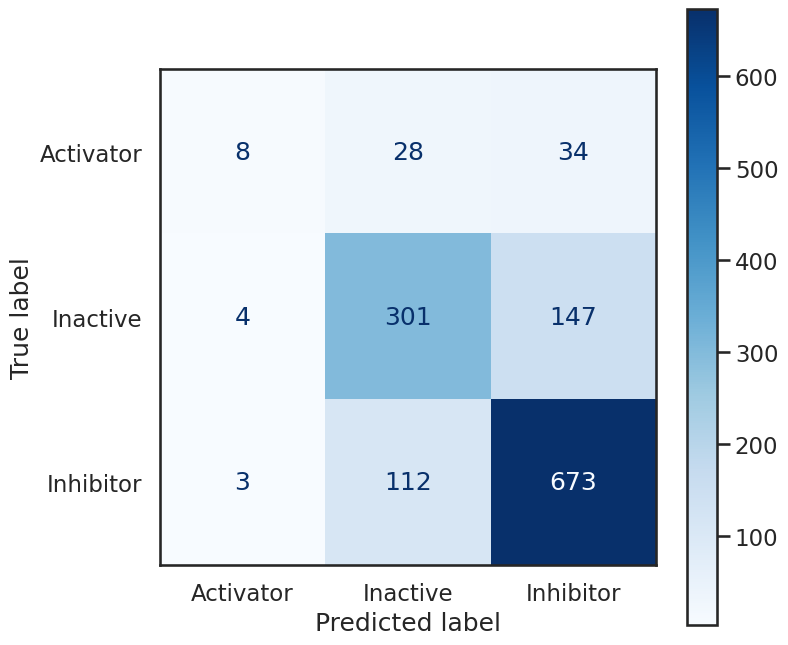

In [ ]:
sns.set_style("white")
sns.set_context('talk')
plt.rcParams["figure.figsize"] = (8,8)
# Mudança em relação ao código original do notebook, pois o método plot_confusion_matrix não funciona mais
disp = ConfusionMatrixDisplay.from_estimator(lgbm, test_X, test_y, display_labels=sorted(labels), cmap=plt.cm.Blues)

### Criação do modelo 

In [25]:
from imblearn.over_sampling import RandomOverSampler

In [26]:
ros = RandomOverSampler()
resample_X, resample_y = ros.fit_resample(train_X,train_y)

In [27]:
pd.Series(train_y).value_counts()

label
2    2252
1    1407
0     270
Name: count, dtype: int64

In [28]:
pd.Series(resample_y).value_counts()

label
2    2252
0    2252
1    2252
Name: count, dtype: int64

In [29]:
resample_lgbm = LGBMClassifier()
resample_lgbm.fit(resample_X, resample_y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9736
[LightGBM] [Info] Number of data points in the train set: 6756, number of used features: 1897
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier()

### Avaliação do modelo oversampled

In [30]:
resample_pred = resample_lgbm.predict_proba(test_X)
roc_auc_score(test_y,resample_pred,multi_class='ovr',average='macro')

np.float64(0.7679597986349416)

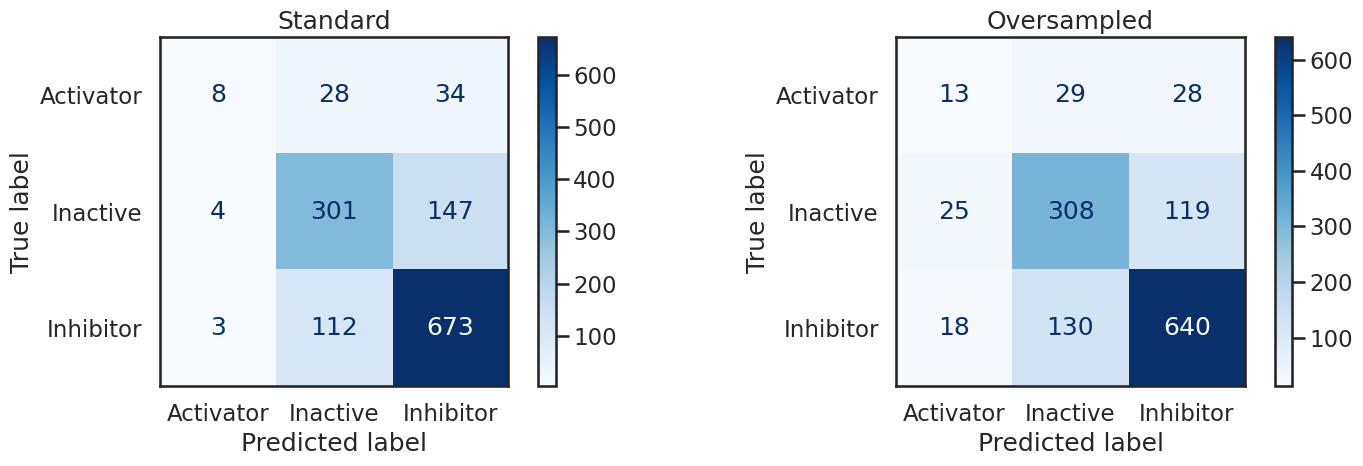

In [32]:
sns.set_style("white")
sns.set_context('talk')
classifiers = [lgbm,resample_lgbm]
titles = ["Standard","Oversampled"]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
for cls,ax,title in zip(classifiers, axes, titles):
    ConfusionMatrixDisplay.from_estimator(cls,test_X,test_y,display_labels=sorted(labels),cmap=plt.cm.Blues,ax=ax)
    ax.title.set_text(title)
plt.tight_layout()

### Comparando modelos padrão e oversampled

In [33]:
res = []
for i in tqdm(range(0,10)):
    # split the data into training and test sets
    train, test = train_test_split(data_df)
    train_X = np.stack(train.desc)
    train_y = train.label
    test_X = np.stack(test.desc)
    test_y = test.label
    # Create the standard model
    lgbm = LGBMClassifier()
    lgbm.fit(train_X,train_y)
    pred = lgbm.predict_proba(test_X)
    auc = roc_auc_score(test_y,pred,multi_class='ovo',average='macro')
    # Create the resampled model
    resample_lgbm = LGBMClassifier()
    resample_X, resample_y = ros.fit_resample(train_X,train_y)
    resample_lgbm.fit(resample_X, resample_y)
    resample_pred = resample_lgbm.predict_proba(test_X)
    resample_auc = roc_auc_score(test_y,resample_pred,multi_class='ovr',average='macro')
    res.append([auc, resample_auc])

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9166
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1619
[LightGBM] [Info] Start training from score -2.738806
[LightGBM] [Info] Start training from score -1.035491
[LightGBM] [Info] Start training from score -0.544209
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9721
[LightGBM] [Info] Number of data points in the train set: 6840, number of used features: 1895
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 10%|█         | 1/10 [00:02<00:26,  2.93s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9162
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1617
[LightGBM] [Info] Start training from score -2.742751
[LightGBM] [Info] Start training from score -1.024086
[LightGBM] [Info] Start training from score -0.550810
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9711
[LightGBM] [Info] Number of data points in the train set: 6795, number of used features: 1888
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

 20%|██        | 2/10 [00:05<00:21,  2.75s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9181
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1630
[LightGBM] [Info] Start training from score -2.730963
[LightGBM] [Info] Start training from score -1.031199
[LightGBM] [Info] Start training from score -0.547724
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9754
[LightGBM] [Info] Number of data points in the train set: 6816, number of used features: 1918
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 30%|███       | 3/10 [00:08<00:19,  2.74s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9168
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1622
[LightGBM] [Info] Start training from score -2.754679
[LightGBM] [Info] Start training from score -1.033342
[LightGBM] [Info] Start training from score -0.543771
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9719
[LightGBM] [Info] Number of data points in the train set: 6843, number of used features: 1901
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9187
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1627
[LightGBM] [Info] Start training from score -2.742751
[LightGBM] [Info] Start training from score -1.031913
[LightGBM] [Info] Start training from score -0.545965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9737
[LightGBM] [Info] Number of data points in the train set: 6828, number of used features: 1899
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

 50%|█████     | 5/10 [00:14<00:13,  2.79s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9211
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1639
[LightGBM] [Info] Start training from score -2.778972
[LightGBM] [Info] Start training from score -1.049204
[LightGBM] [Info] Start training from score -0.531570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9722
[LightGBM] [Info] Number of data points in the train set: 6927, number of used features: 1893
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

 60%|██████    | 6/10 [00:16<00:10,  2.74s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9177
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1626
[LightGBM] [Info] Start training from score -2.674021
[LightGBM] [Info] Start training from score -1.040521
[LightGBM] [Info] Start training from score -0.548605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9745
[LightGBM] [Info] Number of data points in the train set: 6810, number of used features: 1907
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

 70%|███████   | 7/10 [00:19<00:07,  2.65s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9188
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1630
[LightGBM] [Info] Start training from score -2.758687
[LightGBM] [Info] Start training from score -1.035491
[LightGBM] [Info] Start training from score -0.542019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9741
[LightGBM] [Info] Number of data points in the train set: 6855, number of used features: 1910
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


 80%|████████  | 8/10 [00:21<00:05,  2.62s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1630
[LightGBM] [Info] Start training from score -2.711620
[LightGBM] [Info] Start training from score -1.037643
[LightGBM] [Info] Start training from score -0.545965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9735
[LightGBM] [Info] Number of data points in the train set: 6828, number of used features: 1904
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Star

 90%|█████████ | 9/10 [00:24<00:02,  2.56s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9197
[LightGBM] [Info] Number of data points in the train set: 3929, number of used features: 1634
[LightGBM] [Info] Start training from score -2.754679
[LightGBM] [Info] Start training from score -1.017024
[LightGBM] [Info] Start training from score -0.553905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9728
[LightGBM] [Info] Number of data points in the train set: 6774, number of used features: 1901
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


In [34]:
res = np.array(res)
res_df = pd.DataFrame(res,columns=["Standard","Oversampled"])

res_df.head()

,Standard,Oversampled
0,0.730685,0.770148
1,0.740753,0.764622
2,0.721492,0.761717
3,0.747718,0.770060
4,0.753054,0.776326


In [36]:
melt_df = res_df.melt()
melt_df.columns = ["Method","AUC"]

melt_df

,Method,AUC
0,Standard,0.730685
1,Standard,0.740753
2,Standard,0.721492
3,Standard,0.747718
4,Standard,0.753054
5,Standard,0.748336
6,Standard,0.758558
7,Standard,0.731806
8,Standard,0.740270
9,Standard,0.740558


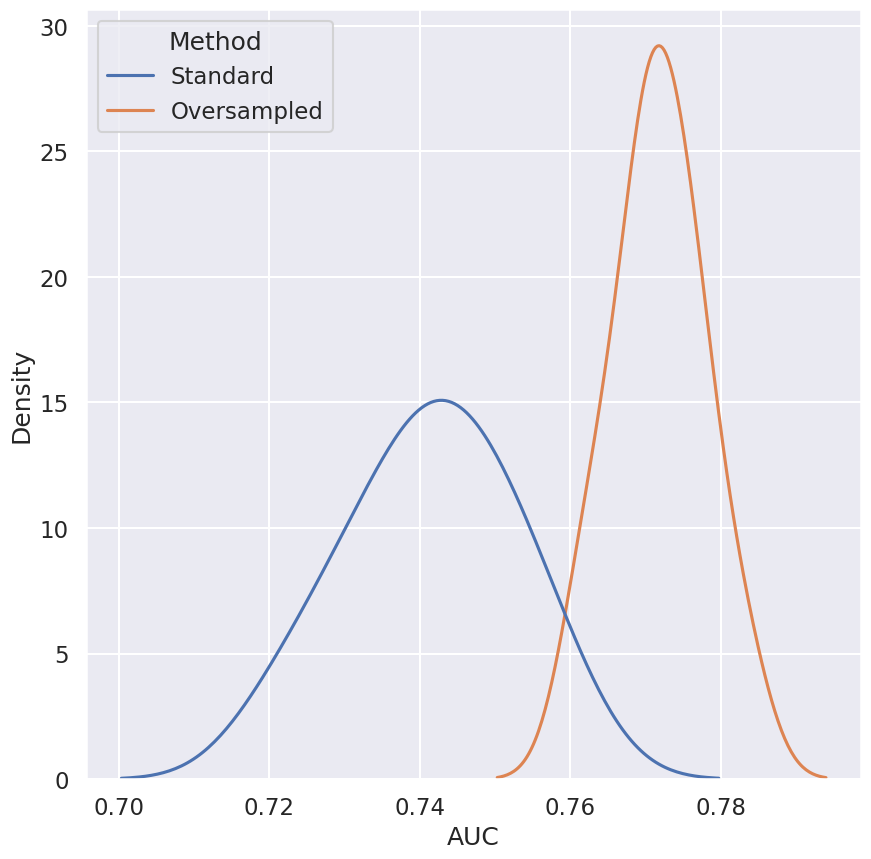

In [37]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_context('talk')
sns.kdeplot(x="AUC",hue="Method",data=melt_df);

In [38]:
from pingouin import wilcoxon, plot_paired

/home/carlosh/ia_web_python/project_env/lib/python3.10/site-packages/pingouin/plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


<Axes: xlabel='wthn', ylabel='AUC'>

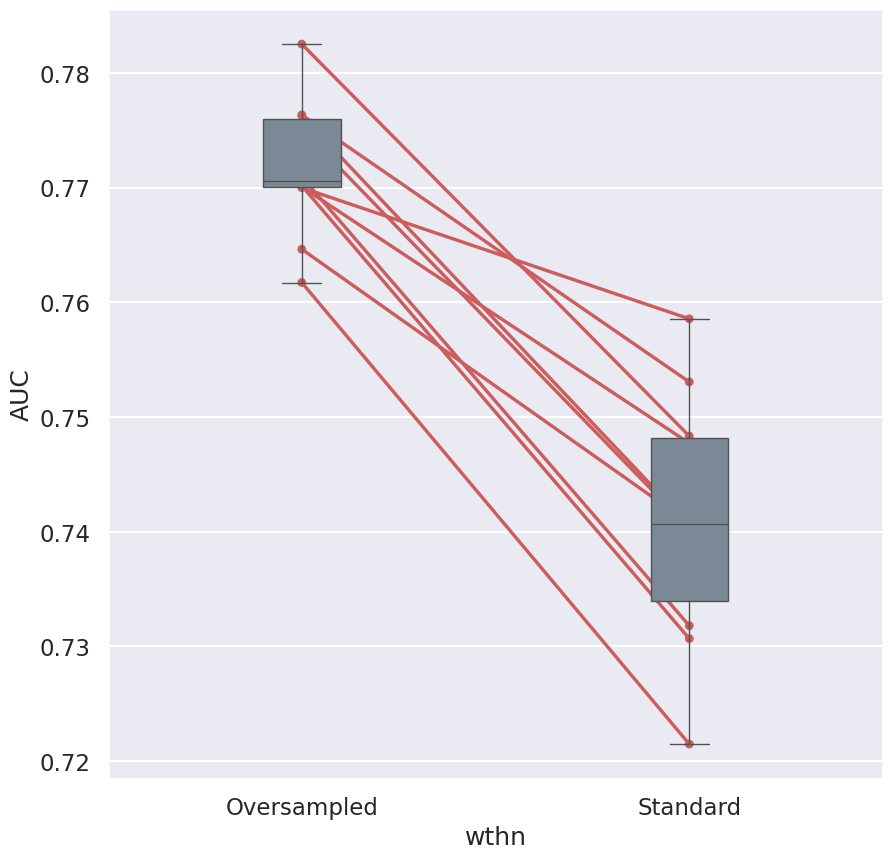

In [39]:
melt_df['cycle'] = list(range(0,10))+list(range(0,10))
plot_paired(data=melt_df,dv="AUC",within="Method",subject="cycle")

In [40]:
wilcoxon(res_df.Standard,res_df.Oversampled)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,0.0,two-sided,0.001953,-1.0,0.0


### Exportação do modelo

In [41]:
import joblib

In [44]:
joblib.dump(lgbm, 'models/model.pkl')

joblib.dump(resample_lgbm, 'models/oversampled_model.pkl')

['models/oversampled_model.pkl']